In [11]:
import requests
import json 
from dotenv import dotenv_values

import pandas as pd

In [12]:
#Read private API key 
#Note: will need to deal with this with Heroku's config vars for deployment
config = dotenv_values('.env')
etsy_key = config['x-api-key']


In [13]:
headers = { 'x-api-key' : etsy_key }

# Part I: Download basic listing data (price, dimensions, materials, etc.) for all paintings for sale within a certain price range. 

## Preparatory Steps

### Get the full hierarchy tree of seller taxonomy nodes, to find the one I am interested in (paintings)

In [14]:
url_taxonomy = 'https://openapi.etsy.com/v3/application/seller-taxonomy/nodes'

In [15]:
response_taxonomy = requests.get(url_taxonomy, headers = headers)

In [21]:
response_taxonomy

<Response [429]>

In [22]:
response_taxonomy.reason

'Too Many Requests'

In [17]:
response_taxonomy_data = response_taxonomy.json() 

In [18]:
response_taxonomy_data.keys()

dict_keys(['error'])

In [19]:
#results is a list of nested dictionaries
len(response_taxonomy_data['results'])

KeyError: 'results'

In [ ]:
#lets's start with the main tree to see the 15 main categories and find where painting may be
[(main_category['name'], counter) for counter, main_category in enumerate(response_taxonomy_data['results'])]

In [ ]:
#Let's dive into Art and Collectibles
[(art_category['name'], counter) for counter, art_category in enumerate(response_taxonomy_data['results'][1]['children'])]
#response_taxonomy_data['results'][1]['children']

In [ ]:
#Let's look at painting
response_taxonomy_data['results'][1]['children'][5]

In [ ]:
#Paintings are themselves divided into different groups based on materials, and there are no more children, so I can now collect the taxonomy id's and the full path taxonomy id's just in case
paintings_taxonomy_list = [(painting_category['name'], painting_category['id'], painting_category['full_path_taxonomy_ids']) for painting_category in response_taxonomy_data['results'][1]['children'][5]['children']]
paintings_taxonomy_list

### Paintings taxonomy

In [ ]:
paintings_taxonomy_df = pd.DataFrame(paintings_taxonomy_list, columns = ['Material','Taxonomy Id','Full path Id'])

In [ ]:
paintings_taxonomy_df

In [ ]:
#I am also adding the number of available paintings in the price range of my interest ($250-$500), which I manually checked (as of 10/5):
#paintings_taxonomy_df['num_listings_250to500USD']=[75333, 4084, 579, 1088, 1137, 6312, 77630, 354, 16597]
paintings_taxonomy_df['num_listings_250to750USD']=[92172, 5068, 721, 1299, 1371, 8026, 97396, 422, 19796]

In [ ]:
paintings_taxonomy_df

In [ ]:
paintings_taxonomy_df['num_listings_250to750USD'].sum()

In [ ]:
paintings_taxonomy_df.set_index('Taxonomy Id')


In [ ]:
paintings_taxonomy_df.set_index('Taxonomy Id').loc[106]

In [ ]:
#Now let's request the properties given for each listing in these categories, with a separate request
url_properties_acrylic = 'https://openapi.etsy.com/v3/application/seller-taxonomy/nodes/106/properties'
response_properties_acrylic = requests.get(url_properties_acrylic, headers = headers)
response_properties_acrylic_data = response_properties_acrylic.json() 

In [ ]:
response_properties_acrylic_data.keys()

In [ ]:
paintings_property_list_acrylic = [(painting_property['property_id'], painting_property['name']) for painting_property in response_properties_acrylic_data['results']]
paintings_property_list_acrylic

In [ ]:
#Let's check that the same properties and code apply to the other paintings' types, e.g. spray paint:

url_properties_spraypaint = 'https://openapi.etsy.com/v3/application/seller-taxonomy/nodes/113/properties'
response_properties_spraypaint = requests.get(url_properties_spraypaint, headers = headers)
response_properties_spraypaint_data = response_properties_spraypaint.json() 


In [ ]:
paintings_property_list_spraypaint = [(painting_property['property_id'], painting_property['name']) for painting_property in response_properties_spraypaint_data['results']]
paintings_property_list_spraypaint

In [ ]:
#So this confirms that the possible properties for a painting don't change by material 

In [ ]:
paintings_properties_df = pd.DataFrame(paintings_property_list_spraypaint, columns = ['Property Id','Property'])

In [ ]:
paintings_properties_df

### Test GET request of the 'find all listings' type

limit = num. listings to return (1-100, default 25)

offset = for skipping responses (default 0)

#keywords = search term or phrase that must appear (e.g. tree)

sort_on = can be ('created', 'price', 'updated', default 'created')

sort_order = 'ascending' or 'descending'

min_price, max_price 

taxonomy_id = code for the type of painting: (106-114, 106 = acrylic, ...., 114=watercolor)

In [ ]:
params = { 'limit' :100, #listings to return (1-100, default 25)
            'offset' : 0,  #for skipping responses (default 0)
            'sort_on': 'price',  #can be ('created', 'price', 'updated', default 'created')
            'sort_order' : 'ascending', #'descending'
             'min_price' : 250.0,
             'max_price' : 750.0,
             'taxonomy_id' : 106 #106 = acrylic, ...., 114=watercolor 
         }

In [ ]:
url_listings_active = 'https://openapi.etsy.com/v3/application/listings/active'

In [ ]:
response_paintings_active = requests.get(url_listings_active, params=params, headers = headers)

In [ ]:
response_paintings_active

In [ ]:
response_paintings_active_data = response_paintings_active.json() 

In [ ]:
response_paintings_active_data.keys()

In [ ]:
response_paintings_active_data['results'][0:2]

In [ ]:
first_100acrylic_paintings_df =  pd.DataFrame(response_paintings_active_data['results'],columns=['listing_id','user_id','shop_id','title','num_favorers','url','materials','item_length','item_width','item_dimensions_unit','style','price','taxonomy_id'])

In [ ]:
first_100acrylic_paintings_df

In [ ]:
first_100acrylic_paintings_df =  pd.DataFrame(response_paintings_active_data['results'])
first_100acrylic_paintings_df

In [ ]:
#Other available requests are: 'FindAllActiveListingsbyShop', 'getListing' (to get a single listing), 'getListingsByListingIds' (pass a list of ids),  'getListingProperties' (to return a single property by id)
#'getAllListingFiles' that returns all the files associated to a listing (including images?) - this requires OAuth2 

In [ ]:
#Test of concatenation
first50acrylic_paintings_df = first_100acrylic_paintings_df.iloc[:50]

In [ ]:
second50acrylic_paintings_df = first_100acrylic_paintings_df.iloc[50:]

In [ ]:
first50acrylic_paintings_df = pd.concat([first50acrylic_paintings_df,second50acrylic_paintings_df])

In [ ]:
first50acrylic_paintings_df

In [ ]:
test = first50acrylic_paintings_df.iloc[98]['price']
test['amount']/test['divisor']

## Here is the actual loop requesting, organizing and saving all paintings listings of a particular material (from code 106=acrylic to code 114=watercolor) within the $250-750 price range  

In [ ]:
from ediblepickle import checkpoint
import os
from urllib.parse import quote

cache_dir = './Git_exclude/cache'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

In [ ]:
import time

In [ ]:
from retrying import retry

In [ ]:
url_listings_active = 'https://openapi.etsy.com/v3/application/listings/active'

In [ ]:
#This is the main workhorse function  to get 100 listings at a time, transform to dataframe and 
#the first decorator saves the results of any call with given parameters to cache, the second one keeps retrying if attampts fail
@retry(stop_max_attempt_number=100,wait_fixed=1000)
@checkpoint(key=lambda args, kwargs: 'tax'+ str(args[0]) + '_off'+ str(args[1]) + '_from' +str(int(min_price)) +'.pkl', work_dir=cache_dir)
def get_100painting_listings(taxonomy_id,offset,min_price,max_price):
    #basic parameters for the getAllListings call
    params = {'limit' :100, #listings to return (1-100, default 25)
            'offset' : offset,  #for skipping responses (default 0, it seems to work only up to 12000)
            'sort_on': 'price',  #can be ('created', 'price', 'updated', default 'created')
            'sort_order' : 'ascending', #'descending'
             'min_price' : min_price,
             'max_price' : max_price,
             'taxonomy_id' : taxonomy_id #106 = acrylic, 107 = combination,  ...., 114=watercolor 
              }
    response_100paintings = requests.get(url_listings_active, params=params, headers = headers)
    response_100paintings_data = response_100paintings.json() 
    response_100paintings_df =  pd.DataFrame(response_100paintings_data['results'])
    return response_100paintings_df

In [ ]:
#I want a function to format the prices, that are returned by Etsy as a weird string like:
#"{'amount': 25000, 'divisor': 100, 'currency_code': 'USD'}"
#I want to convert the price into a floating value (amount/divisor) and throw away price that are not in USDollars as that would throw off my algorithm
import numpy as np
def format_price_USD(price_field_Etsy):
    if price_field_Etsy['currency_code']=='USD':
        return price_field_Etsy['amount']/price_field_Etsy['divisor']
    else:
        return np.nan

In [ ]:
#Testing the basic iteration on taxonomy_id = 107 (combination) since there shouldn't be too many of these listings

# taxonomy_id = 107

# min_price = 250.0
# max_price = 750.0

# tax107_filename = './Git_exclude/Data/tax107_all_paintings_from_USD250.csv'

# #If the files with the listing data already exists for this taxonomy id, I load it:
# try:
#     tax107_all_paintings_df_test = pd.read_csv(tax107_filename)

#     print('Loaded listings file for taxonomy id 107.')

# except:

#     #Let's launch it a first time to initialize the dataframe with the first 100 listings of a given type
#     offset = 0
#     tax107_all_paintings_df = get_100painting_listings(taxonomy_id,offset,min_price,max_price)
    
#     #Then iterate over all paintings of that same type, which number is given in the paintings taxonomy df filled earlier
#     tax107_num_listings = paintings_taxonomy_df.set_index('Taxonomy Id').loc[107]['num_listings_250to750USD']
#     tax107_offsets_list = range(100,tax107_num_listings,100)
    
#     for offset in tax107_offsets_list:
#         tax107_100paintings_df = get_100painting_listings(107,offset,min_price,max_price)
#         tax107_all_paintings_df = pd.concat([tax107_all_paintings_df, tax107_100paintings_df])
#         time.sleep(1)
    
#     #save to .csv file
#     tax107_all_paintings_df.to_csv(tax107_filename,index=False)
        
#     print('Saved listings file for taxonomy id 107.')    

In [ ]:
#Testing a more complicated iteration on taxonomy_id = 114, which has ~20000 entries, but I want to break the results into chunks of at most 12000 entries each
#because request calls with offset>=12000 fail and so need to be handled appropriately

# taxonomy_id = 114

# tax114_filename = './Git_exclude/Data/tax114_all_paintings_from_USD250.csv'

# #total number of listings:
# tax_id_num_listings = paintings_taxonomy_df.set_index('Taxonomy Id').loc[taxonomy_id]['num_listings_250to750USD']
# tax_id_num_listings

# #starting offsets for each chunk:
# starting_offsets = range(0,tax_id_num_listings,12000)

# min_price = 250.0
# max_price = 750.0

# for i,starting_offset in enumerate(starting_offsets):
    
#     if i>0:
#         tax114_next_csv_filename = tax114_filename[:-4]+f'_{i}.csv'
#     else:
#         tax114_next_csv_filename = tax114_filename
    

#     #If the files with the listing data already exists for this taxonomy id, I load it:
#     try:
#         tax_id_all_paintings_df = pd.read_csv(tax114_next_csv_filename)

#         print(f'Loaded listings file {tax114_next_csv_filename} for taxonomy id {taxonomy_id}.')

#     except:

#         #Since the GET request seem to work only for offset<=12000, i.e. only for the first iteration of this code, for the following iterations
#         #I use the following trick: after every multiple of 12000, I update the min price to look for and then use offset numbers modulo 12000
        
#         #Let's launch get_100painting_listings a first time to initialize the dataframe with the first 100 listings of a given type
#         tax_id_all_paintings_df = get_100painting_listings(taxonomy_id,starting_offset%12000,min_price,max_price)

#         #Then iterate attaching 100 painting listings at a time until reaching 12000 or the end
#         if i<(len(starting_offsets)-1):
#             tax_id_offsets_list = range(starting_offset+100,starting_offsets[i+1],100)
#         else:
#             tax_id_offsets_list = range(starting_offset+100,tax_id_num_listings,100)

#         for offset in tax_id_offsets_list:
#             tax_id_100paintings_df = get_100painting_listings(taxonomy_id,offset%12000,min_price,max_price)
#             tax_id_all_paintings_df = pd.concat([tax_id_all_paintings_df, tax_id_100paintings_df])
#             time.sleep(1)
            
#         #if I reached here and this is not the last call, update the min price to the next integer value so that the next block of 12000 offsets does not overlap with the previous
#         #set of entries:
#         if i<(len(starting_offsets)-1):
#             last_price_field = tax_id_all_paintings_df.iloc[-1]['price']
#             min_price = 0.1 + (last_price_field['amount']/last_price_field['divisor'])
            
#         #save to .csv file
#         tax_id_all_paintings_df.to_csv(tax114_next_csv_filename,index=False)
#         print(f'Saved listings file {tax114_next_csv_filename} for taxonomy id {taxonomy_id}.')

    

In [ ]:
#Iterate over all taxonomies of interest

taxonomies_of_interest = [106, 107, 108, 109, 110, 111, 112, 113, 114]

for taxonomy_id in taxonomies_of_interest:

    min_price = 250.0
    max_price = 750.0
    
    csv_filename = f'./Git_exclude/Data/tax{taxonomy_id}_all_paintings_from_USD{int(min_price)}.csv'
    
    #total number of listings:
    tax_id_num_listings = paintings_taxonomy_df.set_index('Taxonomy Id').loc[taxonomy_id]['num_listings_250to750USD']

    #I want to break this into chunks of at most 12000 entries each (because requests with larger offsets fail)
    
    #starting offsets for each chunk:
    starting_offsets = range(0,tax_id_num_listings,12000)
    
    for i,starting_offset in enumerate(starting_offsets):

        if i>0:
            next_csv_filename = csv_filename[:-4]+f'_{i}.csv'
        else:
            next_csv_filename = csv_filename

        #If the files with the listing data already exists for this taxonomy id, I load it:
        try:
            tax_id_all_paintings_df = pd.read_csv(next_csv_filename)

            print(f'Loaded listings file {next_csv_filename} for taxonomy id {taxonomy_id}.')
            
            #if I reached here and this is not the last call, update the min price to the next decimal value so that the next block of 12000 offsets does not overlap with the previous
            #set of entries:
            if i<(len(starting_offsets)-1):
                last_price = tax_id_all_paintings_df.iloc[-1]['price']
                min_price = 0.1 + last_price
                print(min_price)

        except:

            #Since the GET request seem to work only for offset<=12000, i.e. only for the first iteration of this code, for the following iterations
            #I use the following trick: after every multiple of 12000, I update the min price to look for and then use offset numbers modulo 12000

            #Let's launch get_100painting_listings a first time to initialize the dataframe with the first 100 listings of a given type
            tax_id_all_paintings_df = get_100painting_listings(taxonomy_id,starting_offset%12000,min_price,max_price)

            #Then iterate attaching 100 painting listings at a time until reaching 12000 or the end
            if i<(len(starting_offsets)-1):
                tax_id_offsets_list = range(starting_offset+100,starting_offsets[i+1],100)
            else:
                tax_id_offsets_list = range(starting_offset+100,tax_id_num_listings,100)

            for offset in tax_id_offsets_list:
                tax_id_100paintings_df = get_100painting_listings(taxonomy_id,offset%12000,min_price,max_price)
                tax_id_all_paintings_df = pd.concat([tax_id_all_paintings_df, tax_id_100paintings_df])
                time.sleep(1)

            #clean the price column by making it into a float and removing if currency is not USD    
            tax_id_all_paintings_df['price']=tax_id_all_paintings_df['price'].apply(format_price_USD)
            tax_id_all_paintings_df.dropna(axis=0,subset=['price'],inplace=True)
                
            #if I reached here and this is not the last call, update the min price to the next decimal value so that the next block of 12000 offsets does not overlap with the previous
            #set of entries:
            if i<(len(starting_offsets)-1):
                last_price = tax_id_all_paintings_df.iloc[-1]['price']
                min_price = 0.1 + last_price

            #save to .csv file
            tax_id_all_paintings_df.to_csv(next_csv_filename,index=False)
            print(f'Saved listings file {next_csv_filename} for taxonomy id {taxonomy_id}.')


# PART 2: Reorganize downloaded raw files, combine taxonomy types, remove entries without critical information (dimensions, etc.), etc

In [ ]:
#The taxonomy numbers are quite skewed: >50000 entries for 106 (acrylic) and 112 (oil), around 15000 for 114 (watercolor), around 4-5000 each for 107 (Combination) and 111 (Mixed),
#but less than 1000 for all the other taxonomies. Hence I will drop all these other minor taxonomies, combine 107 and 111 in a new 'More than one' category and will at the end
#have 4 categories: acrylic, oil, watercolor, more_than_one

In [ ]:
#I will use taxonomy 114 (watercolors) as the example one to refine the data-cleaning pipeline because it has enough entries that the data is split into more than one file,
#but is not as large as oil or acrylic which have 8 files each

In [ ]:
taxonomy_id = 114

csv_filename_pattern = f'./Git_exclude/Data/tax{taxonomy_id}_all_paintings*.csv'


In [ ]:
csv_filename_pattern

In [ ]:
import glob

tax_csv_files = glob.glob(csv_filename_pattern)
tax_csv_files

In [ ]:
tax_114_paintings_df_temp = pd.read_csv(tax_csv_files[0])

In [ ]:
tax_114_paintings_df_temp.head()

In [ ]:
tax_114_paintings_df_temp.info()

In [ ]:
tax_114_paintings_df_temp.describe()

Info in the dataframe:
1) identifiers of the painting and author/owner: listing_id, user_id, shop_id, shop_section_id, shipping_profile_id, url
   This will not be needed in the model, but will need to keep track of listing_id and shop_id for cross reference, and the url to show the user if applicable
2) price: the target variable



In [ ]:
#let's see the distribution of prices in the dataset
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.distplot(tax_114_paintings_df_temp['price'])

3) dimensions information (and weight): this is critical for modeling so I must process it and remove those that are missing such info
   item_length, item_width, item_height, dimension_unit, item_weight, weight_unit -> lenght, width, height, area (all in inches), weight (in oz), aspect ratio 

In [ ]:
tax_114_paintings_df_temp['item_length'].isna()

In [ ]:
#I am not sure why the dimensions are missing from the table when if I look at the url it shows the dimensions...
tax_114_paintings_df_temp.iloc[0]['url']

In [ ]:
tax_114_paintings_df_temp.iloc[0]

In [ ]:
tax_114_paintings_df_temp.iloc[4]['url']

In [ ]:
tax_114_paintings_df_temp.iloc[4]

In [ ]:
tax_114_paintings_df_temp['item_dimensions_unit'].unique()

In [ ]:
tax_114_paintings_df_temp['item_weight_unit'].unique()

In [ ]:
#Item dimensions are critical for estimating the price, so I am going to have to drop all the entries that have nan's in either item length or item width or item_dimensions_unit
#I do the same for weight since it's possible that there may be important information there (e.g. if the painting has a frame and is bigger it will weigh more)
tax_114_paintings_df_temp.dropna(axis=0,subset=['item_length','item_width','item_height','item_dimensions_unit','item_weight','item_weight_unit'],inplace=True)

In [ ]:
len(tax_114_paintings_df_temp)

In [ ]:
#LEt's see an example of entry in which the units are mm
tax_114_paintings_df_temp[tax_114_paintings_df_temp['item_dimensions_unit']=='mm']['item_length']

In [ ]:
tax_114_paintings_df_temp.iloc[4][['item_length','item_width','item_dimensions_unit']]

In [ ]:
#Let me process all the dimensions (converting measurement units, etc.) with the following function, that also creates new columns 'area' and 'aspect_ratio' (defined by width/length)
def format_dimensions(length,width,unit):
    if unit=='in':
        area=width*length
        aspect_ratio=width/length
        return length,width,area,aspect_ratio
    elif unit=='mm':
        area=(width/25.4)*(length/25.4)
        aspect_ratio=width/length
        return length/25.4,width/25.4,area,aspect_ratio
        

In [ ]:
#need to make sure this gets executed only once, so I drop the column with the units afterwards
tax_114_paintings_df_temp['length']=tax_114_paintings_df_temp[['item_length','item_dimensions_unit']].apply(lambda x:x[0]/25.4 if x[1]=='mm' else x[0], axis=1)
tax_114_paintings_df_temp['width']=tax_114_paintings_df_temp[['item_width','item_dimensions_unit']].apply(lambda x:x[0]/25.4 if x[1]=='mm' else x[0], axis=1)
tax_114_paintings_df_temp['height']=tax_114_paintings_df_temp[['item_height','item_dimensions_unit']].apply(lambda x:x[0]/25.4 if x[1]=='mm' else x[0], axis=1)
tax_114_paintings_df_temp.drop(['item_length','item_width','item_height','item_dimensions_unit'],axis=1,inplace=True)
#this is safer because sometimes people confuse height, length and width
tax_114_paintings_df_temp['area']=tax_114_paintings_df_temp[['width','length','height']].apply(lambda x:(np.max(x)*np.median(x)), axis=1) 
tax_114_paintings_df_temp['aspect_ratio']=tax_114_paintings_df_temp[['width','length','height']].apply(lambda x:(np.max(x)/np.median(x)), axis=1)

In [ ]:
#similar processing for the weight
tax_114_paintings_df_temp['item_weight_unit'].unique()

In [ ]:
tax_114_paintings_df_temp[tax_114_paintings_df_temp['item_weight_unit']=='g']['item_weight'][:4]

In [ ]:
tax_114_paintings_df_temp['weight']=tax_114_paintings_df_temp[['item_weight','item_weight_unit']].apply(lambda x:x[0]/28.3495 if x[1]=='g' else x[0], axis=1)
tax_114_paintings_df_temp.drop(['item_weight','item_weight_unit'],axis=1,inplace=True)

In [ ]:
tax_114_paintings_df_temp.describe()

4) Info about when piece was created or added into the system - original_creation_timestamp, when_made

In [ ]:
tax_114_paintings_df_temp['when_made'].unique()

In [ ]:
grouped_by_made_period = tax_114_paintings_df_temp.groupby(by='when_made')

In [ ]:
grouped_by_made_period['listing_id'].count()

In [ ]:
#it looks like the overwhelming majority of paintings is either done in the past 1-2 years or in the previous decade (2010-2019) so this variable may not be that informative.
#I can perhaps use this as categorical data with 4 categories like ['made_to_order','made_2020s','made_2010s','made_before_2010']
#First, let's check how many entries are missing the 'when made' tag to make sure we are not dropping too many cells if we decide to use this

In [ ]:
sum(tax_114_paintings_df_temp['when_made'].isna())

In [ ]:
#Drop the rows without 'when_made'
tax_114_paintings_df_temp.dropna(axis=0,subset=['when_made'],inplace=True)

In [ ]:
def format_when_made(when_made):
    if when_made=='made_to_order':
        return 'made_to_order'
    elif when_made=='2020_2021':
        return 'made_2020s'
    elif when_made=='2010_2019':
        return 'made_2010s'
    else:
        return 'made_before_2010'

In [ ]:
#tax_114_paintings_df_temp['when_made']=tax_114_paintings_df_temp['when_made'].apply(lambda x:format_when_made(x), axis=1)
tax_114_paintings_df_temp['when_made']=tax_114_paintings_df_temp['when_made'].apply(lambda x:format_when_made(x)) #, axis=1)

In [ ]:
tax_114_paintings_df_temp.iloc[38]

In [ ]:
#Next let's look at the age of a listing (which may or may not related to when the painting was actually created) and when it was last updated

In [ ]:
from datetime import datetime
#let's use end of the year as the reference day to which comparing every other date
ref_date = datetime.strptime('2021-Dec-31','%Y-%b-%d') 
ref_date

In [ ]:
tax_114_paintings_df_temp['days_from_original_creation'] = tax_114_paintings_df_temp['original_creation_timestamp'].apply(lambda x:(datetime.strptime('2021-Dec-31','%Y-%b-%d')-datetime.fromtimestamp(x)).days) #, axis=1)

In [ ]:
tax_114_paintings_df_temp['days_from_last_modification'] = tax_114_paintings_df_temp['last_modified_timestamp'].apply(lambda x:(datetime.strptime('2021-Dec-31','%Y-%b-%d')-datetime.fromtimestamp(x)).days) #, axis=1)

In [ ]:
tax_114_paintings_df_temp.describe()

In [ ]:
#I can now drop all the other timestamp variables
tax_114_paintings_df_temp.drop(['creation_timestamp','ending_timestamp','original_creation_timestamp','last_modified_timestamp','state_timestamp'],axis=1,inplace=True)

In [ ]:
tax_114_paintings_df_temp.describe()

5) Rankings given by either the seller or users: 'featured_rank', 'num_favorers'

In [ ]:
#How many paintings have favorers
tax_114_paintings_df_temp['num_favorers'].unique()

In [ ]:
#many paintings have non-zero number of favorers, so this may be a useful attribute
len(tax_114_paintings_df_temp[tax_114_paintings_df_temp['num_favorers']>0])

In [ ]:
#However, is it missing in many paintings? No
sum(tax_114_paintings_df_temp['num_favorers'].isna())

In [ ]:
#Let's check featured_rank:
tax_114_paintings_df_temp['featured_rank'].unique()

In [ ]:
#many paintings have featured_rank different from default -1? Not very many, but it may be important and it is not missing in any entry, so I will leave this alone
len(tax_114_paintings_df_temp[tax_114_paintings_df_temp['featured_rank']!=-1])

In [ ]:
sum(tax_114_paintings_df_temp['featured_rank'].isna())

6) A bunch of misc variable that may or may not matter, most of whilch I'll remove except the first few

In [ ]:
#Who made the painting? Seller or somebody else?
tax_114_paintings_df_temp['who_made'].value_counts()

In [ ]:
#Let's redefine the above as a boolean: seller made TRUE or FALSE (if someone_else or collective made it)
tax_114_paintings_df_temp['made_by_seller']=tax_114_paintings_df_temp['who_made'].apply(lambda x:True if 'i_did' else False) #, axis=1)

In [ ]:
#Drop the original column
tax_114_paintings_df_temp.drop(['who_made'],axis=1,inplace=True)

In [ ]:
#Quantity - most of the paintings have only quantity 1, and the other numbers vary a lot, so I will remove this 
tax_114_paintings_df_temp['quantity'].unique()

In [ ]:
len(tax_114_paintings_df_temp[tax_114_paintings_df_temp['quantity']>1])

In [ ]:
sum(tax_114_paintings_df_temp['quantity'].isna())

In [ ]:
#Listing type - this is almost exclusively equal 0, so I will drop this
tax_114_paintings_df_temp['listing_type'].unique()

In [ ]:
len(tax_114_paintings_df_temp[tax_114_paintings_df_temp['listing_type']==1])

In [ ]:
#Non-taxable - very few entries are true, so I will drop this
tax_114_paintings_df_temp['non_taxable'].value_counts()

In [ ]:
#Is personalizable - very few entries are true, so I will drop this
tax_114_paintings_df_temp['is_personalizable'].value_counts()

In [ ]:
#personalization_is_required - very few entries are true, so I will drop this (along with the other 'personalization' info)
tax_114_paintings_df_temp['personalization_is_required'].value_counts()

In [ ]:
#is_supply - very few entries are true, so I will drop this (along with the other )
tax_114_paintings_df_temp['is_supply'].value_counts()

In [ ]:
#is_private - no entries are true, so I will drop this (along with the other )
tax_114_paintings_df_temp['is_private'].value_counts()

In [ ]:
#is_customizable - >500 entries are true, so I will leave this alone
tax_114_paintings_df_temp['is_customizable'].value_counts()

In [ ]:
 #has_variations - ~350 entries are true, so I will leave this alone
tax_114_paintings_df_temp['has_variations'].value_counts()

In [ ]:
#Here is where I drop at once the columns discussed above:
tax_114_paintings_df_temp.drop(['quantity','listing_type','non_taxable','is_personalizable','personalization_is_required','is_supply','is_private'],axis=1,inplace=True)

In [ ]:
#Also drop a bunch of other things that don't matter:

In [ ]:
tax_114_paintings_df_temp.drop(['state','personalization_char_count_max','personalization_instructions','processing_min','processing_max','should_auto_renew','language','production_partners','file_data'],axis=1,inplace=True)

In [ ]:
tax_114_paintings_df_temp.info()

7) Look at 'tags', 'materials' and 'style', word tags that are added in some of the paintings

In [ ]:
#The 'materials' don't seem to add a lot of information (mostly watercolors, paper, etc.) that is not already implied by taxonomy number 
#and on the contrary there may be problems due to different spellings - 
#for now I will keep this column but not use it 
tax_114_paintings_df_temp['materials'].value_counts()[:20]

In [ ]:
#The style tags are added only in a very limited number of cases, so they are unlikely to be helpful - I leave them alone but not use them
tax_114_paintings_df_temp['style'].value_counts()[:20]

In [ ]:
#The generic 'tags' may (or may not) add valuable info but are messy - for now I'll leave them alone -  but I may try to do something smart with this later in machine-learning
tax_114_paintings_df_temp['tags'].value_counts()[:20]

8) Finally I will take care of taxonomy in the way discussed earlier, leaving only 4 types: 'Oil', 'Watercolor', 'Acrylic' and 'More than one' 

In [ ]:
#but less than 1000 for all the other taxonomies. Hence I will drop all these other minor taxonomies, combine 107 and 111 in a new 'More than one' category and will at the end
#have 4 categories: acrylic, oil, watercolor, more_than_one

In [ ]:
tax_114_paintings_df_temp['taxonomy_id'].value_counts()

In [ ]:
def format_taxonomy_id(taxonomy_id):
    if taxonomy_id==106:
        return 'acrylic'
    elif taxonomy_id==112:
        return 'oil'
    elif taxonomy_id==114:
        return 'watercolor'
    elif taxonomy_id in [107,111]:
        return 'more_than_one'
    else:
        return 'other'

In [ ]:
tax_114_paintings_df_temp['painting_type']=tax_114_paintings_df_temp['taxonomy_id'].apply(lambda x:format_taxonomy_id(x)) #, axis=1)

In [ ]:
tax_114_paintings_df_temp['painting_type'].value_counts()

In [ ]:
#So at the end of this cleaning procedure, the first set of ~8000 watercolor paintings (with 45 fields pf information) got reduced to 
#~3561 paintings with ~25 fields of information plus the price target column

In [ ]:
len(tax_114_paintings_df_temp)

In [ ]:
#Of the remaining 26 fields of information, 7 are just useful to identify the artifact (the _id's and url), 
# 5 are textual descriptions/tags that are unlikely to be very helpful (title, description, tags, materials, style),
# 10 are numerical features that will be used in the predictor: featured_rank, num_favorers, length, width, height, area, aspect_ratio, weight, days_from_original_creation, days_from_last_modifications
# 2 are categorical features that will be used in the predictor: painting_type (4 categories), when_made (4 categories)
# 3 are boolean features: is_customizable, has_variations, made_by_seller

In [ ]:
tax_114_paintings_df_temp.info()

### Encapsulate all the preprocessing steps into a single function to be applied to each .csv file of raw data

In [23]:
from datetime import datetime

def format_dimensions(dimension_unit_vec):
    if dimension_unit_vec[1]=='in':
        return dimension_unit_vec[0]
    elif dimension_unit_vec[1]=='mm':
        return dimension_unit_vec[0]/25.4
    elif dimension_unit_vec[1]=='cm':
        return dimension_unit_vec[0]/25.4
    else:
        print(f'measurement unit {dimension_unit_vec[1]} not supported for dimensions')

def format_weight(weight_unit_vec):
    if weight_unit_vec[1]=='oz':
        return weight_unit_vec[0]
    elif weight_unit_vec[1]=='g':
        return weight_unit_vec[0]/28.3495
    else:
        print(f'measurement unit {weight_unit_vec[1]} not supported for weight')
        
def format_when_made(when_made):
    if when_made=='made_to_order':
        return 'made_to_order'
    elif when_made=='2020_2021':
        return 'made_2020s'
    elif when_made=='2010_2019':
        return 'made_2010s'
    else:
        return 'made_before_2010'
    
def format_taxonomy_id(taxonomy_id):
    if taxonomy_id==106:
        return 'acrylic'
    elif taxonomy_id==112:
        return 'oil'
    elif taxonomy_id==114:
        return 'watercolor'
    elif taxonomy_id in [107,111]:
        return 'more_than_one'
    else:
        return 'other'

def clean_listings_dataframe(paintings_orig_df_by_taxonomy):

    #This function will drop the paintings without dimensions info and 'when_made' information.
    #Then for all remaining entries the info is consolidated into 27 fields of information in addition to the target column 'price':
    # 7 fields are just useful to identify the artifact (the _id's and url), 
    # 5 are textual descriptions/tags that are unlikely to be very helpful (title, description, tags, materials, style),
    # 10 are numerical features that will be used in the predictor: featured_rank, num_favorers, length, width, height, area, aspect_ratio, weight, days_from_original_creation, days_from_last_modifications
    # 2 are categorical features that will be used in the predictor: painting_type (4 categories), when_made (4 categories)
    # 3 are boolean features: is_customizable, has_variations, made_by_seller

    #1) Item dimensions are critical for estimating the price, so I am going to have to drop all the entries that have nan's in either item length or item width or item_dimensions_unit
    #I do the same for weight since it's possible that there may be important information there (e.g. if the painting has a frame and is bigger it will weigh more)
    paintings_orig_df_by_taxonomy.dropna(axis=0,subset=['item_length','item_width','item_height','item_dimensions_unit','item_weight','item_weight_unit'],inplace=True)

    #2) process all the dimensions (converting measurement units, etc.) as follows, also creating new columns 'area' and 'aspect_ratio' (defined by max dim/2nd dimension)
    #need to make sure this gets executed only once, so I drop the column with the units afterwards
    paintings_orig_df_by_taxonomy['length']=paintings_orig_df_by_taxonomy[['item_length','item_dimensions_unit']].apply(lambda x:format_dimensions(x), axis=1)
    paintings_orig_df_by_taxonomy['width']=paintings_orig_df_by_taxonomy[['item_width','item_dimensions_unit']].apply(lambda x:format_dimensions(x), axis=1)
    paintings_orig_df_by_taxonomy['height']=paintings_orig_df_by_taxonomy[['item_height','item_dimensions_unit']].apply(lambda x:format_dimensions(x), axis=1)
    paintings_orig_df_by_taxonomy.drop(['item_length','item_width','item_height','item_dimensions_unit'],axis=1,inplace=True)
    #this is safer because sometimes people confuse height, length and width
    paintings_orig_df_by_taxonomy['max_dimension']=paintings_orig_df_by_taxonomy[['width','length','height']].apply(lambda x:np.max(x), axis=1) 
    paintings_orig_df_by_taxonomy['area']=paintings_orig_df_by_taxonomy[['width','length','height']].apply(lambda x:(np.max(x)*np.median(x)), axis=1) 
    paintings_orig_df_by_taxonomy['aspect_ratio']=paintings_orig_df_by_taxonomy[['width','length','height']].apply(lambda x:(np.max(x)/np.median(x)), axis=1)

    #3) process the weight also, by consolidating units and renaming the column 
    paintings_orig_df_by_taxonomy['weight']=paintings_orig_df_by_taxonomy[['item_weight','item_weight_unit']].apply(lambda x:format_weight(x), axis=1)
    paintings_orig_df_by_taxonomy.drop(['item_weight','item_weight_unit'],axis=1,inplace=True)

    #4) The overwhelming majority of paintings is either done in the past 1-2 years or in the previous decade (2010-2019).
    #Create categorical feature with 4 categories like ['made_to_order','made_2020s','made_2010s','made_before_2010'] using the original 'when_made' column
    #Drop the rows without 'when_made'
    paintings_orig_df_by_taxonomy.dropna(axis=0,subset=['when_made'],inplace=True)   
    paintings_orig_df_by_taxonomy['when_made']=paintings_orig_df_by_taxonomy['when_made'].apply(lambda x:format_when_made(x)) #, axis=1)

    #5) Convert timestamps for original creation and last modification into number of days from the end of 2021
    ref_date = datetime.strptime('2021-Dec-31','%Y-%b-%d') 
    paintings_orig_df_by_taxonomy['days_from_original_creation'] = paintings_orig_df_by_taxonomy['original_creation_timestamp'].apply(lambda x:(datetime.strptime('2021-Dec-31','%Y-%b-%d')-datetime.fromtimestamp(x)).days) #, axis=1)
    paintings_orig_df_by_taxonomy['days_from_last_modification'] = paintings_orig_df_by_taxonomy['last_modified_timestamp'].apply(lambda x:(datetime.strptime('2021-Dec-31','%Y-%b-%d')-datetime.fromtimestamp(x)).days) #, axis=1)

    #6) Drop all the other timestamp variables
    paintings_orig_df_by_taxonomy.drop(['creation_timestamp','ending_timestamp','original_creation_timestamp','last_modified_timestamp','state_timestamp'],axis=1,inplace=True)

    #7) Fill the missing values for 'num_favorers' and 'featured_rank' (if any) with the default values 0 and -1 respectively, and the 'who_made' missing values with 'i_did',
    #since these are the overwhelmingly must common cases
    paintings_orig_df_by_taxonomy['num_favorers'].fillna(value=0,inplace=True)
    paintings_orig_df_by_taxonomy['featured_rank'].fillna(value=-1,inplace=True)
    paintings_orig_df_by_taxonomy['who_made'].fillna(value='i_did',inplace=True)
    
    #8) Redefine the 'who_made' variable as a boolean: seller made TRUE or FALSE (if someone_else or collective made it)
    paintings_orig_df_by_taxonomy['made_by_seller']=paintings_orig_df_by_taxonomy['who_made'].apply(lambda x:True if x=='i_did' else False) #, axis=1)
    #Drop the original column
    paintings_orig_df_by_taxonomy.drop(['who_made'],axis=1,inplace=True)

    #9) Drop a bunch of columns that are standard for the great majority of the paintings
    paintings_orig_df_by_taxonomy.drop(['quantity','listing_type','non_taxable','is_personalizable','personalization_is_required','is_supply','is_private'],axis=1,inplace=True)

    #10) Drop a bunch of other info that doesn't matter for the model:
    paintings_orig_df_by_taxonomy.drop(['state','personalization_char_count_max','personalization_instructions','processing_min','processing_max','should_auto_renew','language','production_partners','file_data'],axis=1,inplace=True)

    #11) Create a new 'painting_type' categorical value from 'taxonomy_id' with only 4 categories: acrylic, oil, watercolor, more_than_one
    #(I keep the 'taxonomy_id' column also as an identifier of the item like listing_id, user_id, shop_id, etc.)   
    paintings_orig_df_by_taxonomy['painting_type']=paintings_orig_df_by_taxonomy['taxonomy_id'].apply(lambda x:format_taxonomy_id(x)) #, axis=1)

    #Note: I am leaving alone the 'free text' columns such as 'title', 'description', 'tags', 'materials' and 'style' for possible future use




In [ ]:
#Test the previous procedure on the second subset of watercolor paintings to make sure it works as expected:

taxonomy_id = 114

csv_filename_pattern = f'./Git_exclude/Data/tax{taxonomy_id}_all_paintings*.csv'
tax_csv_files = glob.glob(csv_filename_pattern)
tax_114_paintings_df_temp_2 = pd.read_csv(tax_csv_files[1])

In [ ]:
len(tax_114_paintings_df_temp_2)

In [ ]:
tax_114_paintings_df_temp_2.info()

In [ ]:
clean_listings_dataframe(tax_114_paintings_df_temp_2)

In [ ]:
len(tax_114_paintings_df_temp_2)

In [ ]:
tax_114_paintings_df_temp_2.info()

In [ ]:
#So at the end of this cleaning procedure, the second set of ~5000 watercolor paintings (with 45 fields pf information) got reduced to 
#2200 paintings with ~25 fields of information plus the price target column

### Here is the iteration applying the cleaning procedure to all paintings of all taxonomies of interest, and creating a unique dataframe to carry forward for machine learning

In [24]:
import glob

#I will drop all the minor taxonomies that have less than 1000 paintings each, combine 107 (Combination) and 111 (Mixed) in a new 'More than one' category and will at the end
#have 4 categories with the main taxonomies (106=acrylic, 112=oil, 114=watercolor) + 'more_than_one'

min_price = 250.0

csv_combined_filename = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_cleaned_listings.csv'
    
#If the file with all the cleaned listing data already exists, I load it, otherwise I create it with the cleaning steps chosen above
try:
    all_paintings_df = pd.read_csv(csv_combined_filename)

    print(f'Loaded listings file {csv_combined_filename} with all the cleaned listings (multiple taxonomies).')

except:
    
    try: #it by any chance there is a version of 'all_paintings_df' around, I delete it
        del all_paintings_df
    except NameError:
        pass

    taxonomies_of_interest = [106, 107, 111, 112, 114]

    for taxonomy_id in taxonomies_of_interest:

        csv_filename_pattern_tax_id = f'./Git_exclude/Data/tax{taxonomy_id}_all_paintings*.csv'
        tax_id_csv_files = glob.glob(csv_filename_pattern_tax_id)

        for csv_file in tax_id_csv_files:

            tax_id_paintings_df_temp = pd.read_csv(csv_file)

            clean_listings_dataframe(tax_id_paintings_df_temp)

            try: #concatenate to the other
                all_paintings_df = pd.concat([all_paintings_df, tax_id_paintings_df_temp])
            except: #if it's the first iteration, I need to create the dataframe where the data of all paintings of all taxonomies will be stored
                all_paintings_df = tax_id_paintings_df_temp

    #because of the imbalance in prices (watercolors only had paintings up to 672$, oil up to 700$, acrylic up to 750$ and 'more_than_one' up to 662$), 
    #I only keep paintings with price <= 650$
    all_paintings_df = all_paintings_df[all_paintings_df['price']<=650.0]
    
    #drop all paintings with largest dimension >72in, as those are outliers
    all_paintings_df = all_paintings_df[all_paintings_df['max_dimension']<=72.0]

    #sort by price in ascending order, with listing_id used next to break ties - this should shuffle the 4 painting types
    all_paintings_df.sort_values(by=['price','listing_id'], ascending=True, inplace=True)

    #reset index (dropping old ones that are meaningless)
    all_paintings_df.reset_index(drop=True, inplace=True)
    
    #finally save to .csv file for further processing (machine learning model, etc.) and avoiding to recompute everything late
    all_paintings_df.to_csv(csv_combined_filename,index=False)
    print(f'Saved listings file {csv_combined_filename} with all the cleaned listings (multiple taxonomies).')
    
    

Loaded listings file ./Git_exclude/Data/all_paintings_from_USD250_cleaned_listings.csv with all the cleaned listings (multiple taxonomies).


In [ ]:
len(all_paintings_df)

In [ ]:
#Let's check I have everything as expected
all_paintings_df['taxonomy_id'].value_counts()

In [ ]:
all_paintings_df['painting_type'].value_counts()

C:\Users\matte\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

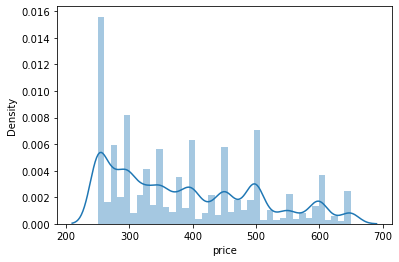

In [25]:
#Let's check the range of prices I have, especially for each painting type
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.distplot(all_paintings_df['price'])

<AxesSubplot:xlabel='price', ylabel='Count'>

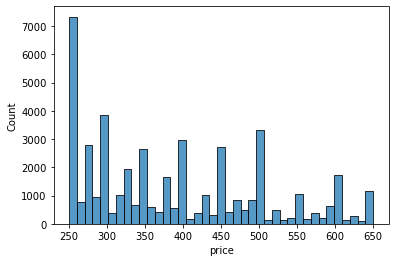

In [26]:
sns.histplot(all_paintings_df['price'])

<AxesSubplot:xlabel='price', ylabel='painting_type'>

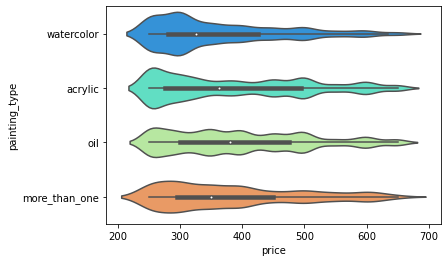

In [27]:
#Let's plot by painting type 
sns.violinplot(x="price", y="painting_type", data=all_paintings_df,palette='rainbow')

In [28]:
all_paintings_df.groupby(by='painting_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
painting_type,,,,,,,,
acrylic,19635.0,388.141653,120.811372,250.0,275.0,362.0,495.0,650.0
more_than_one,2988.0,384.157848,111.782780,250.0,295.0,350.0,450.0,650.0
oil,17473.0,396.342334,111.317943,250.0,299.0,380.0,475.0,650.0
watercolor,5752.0,361.525421,103.776414,250.0,280.0,325.0,425.0,650.0


In [29]:
all_paintings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45848 entries, 0 to 45847
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   45848 non-null  int64  
 1   user_id                      45848 non-null  int64  
 2   shop_id                      45848 non-null  int64  
 3   title                        45848 non-null  object 
 4   description                  45848 non-null  object 
 5   shop_section_id              27170 non-null  float64
 6   featured_rank                45848 non-null  int64  
 7   url                          45848 non-null  object 
 8   num_favorers                 45848 non-null  int64  
 9   is_customizable              45848 non-null  bool   
 10  tags                         45848 non-null  object 
 11  materials                    45848 non-null  object 
 12  shipping_profile_id          30880 non-null  float64
 13  when_made       

In [30]:
all_paintings_df.head()

,listing_id,user_id,shop_id,title,description,shop_section_id,featured_rank,url,num_favorers,is_customizable,...,width,height,max_dimension,area,aspect_ratio,weight,days_from_original_creation,days_from_last_modification,made_by_seller,painting_type
0,28584215,7788342,5612716,Nuala - Original Watercolor (Framed),"This is an original watercolor, titled &quot;N...",6306700.0,-1,https://www.etsy.com/listing/28584215/nuala-or...,10,False,...,26.0,8.0,30.0,780.0,1.153846,240.0,4536,168,True,watercolor
1,40722367,9264578,5800355,US Mail Plane,This is a painting of one of my favorites from...,6798937.0,-1,https://www.etsy.com/listing/40722367/us-mail-...,55,False,...,30.0,4.0,30.0,900.0,1.000000,96.0,4337,134,True,acrylic
2,47095684,9977031,5889085,Garden Window - original watercolor painting,Spring time in Santa Fe with a sunny window lo...,7409641.0,34,https://www.etsy.com/listing/47095684/garden-w...,32,True,...,16.0,1.0,20.0,320.0,1.250000,32.0,4247,90,True,watercolor
3,52229780,5976773,5315957,In the Landscape of the Divine Madness -- A Tr...,I like this one because it came straight from ...,6919244.0,-1,https://www.etsy.com/listing/52229780/in-the-l...,5,True,...,16.0,3.0,19.0,304.0,1.187500,48.0,4177,95,True,oil
4,55639432,9977031,5889085,Kanazawa Side Street - Original Watercolor Pai...,"Pedestrian street in Kanazawa, Japan.\n\n12&qu...",7033660.0,-1,https://www.etsy.com/listing/55639432/kanazawa...,37,True,...,22.0,1.0,26.0,572.0,1.181818,48.0,4133,90,True,watercolor


# PART 3: Preliminary analysis - and further preselection - of combined data from all paintings of all taxonomies of interest

Numerical features

1) Dependence of price on painting dimensions

In [ ]:
sns.jointplot(x='area',y='price',data=all_paintings_df,kind='hex')

In [ ]:
sns.distplot(all_paintings_df['area'])

In [ ]:
pd.set_option('display.max_colwidth',100)
all_paintings_df.sort_values(by='area', ascending=False)[['length','width','height','aspect_ratio','area','weight','price','url']].head(20)

In [ ]:
#I checked and most of the above were outliers, in that either the same number was reported on both height and length, or the reported unit was wrong, or the numbers were flat out reported wrong
#So there will certainly be noise in these numbers, as well as in the aspect ratio and area numbers

In [ ]:
#Let's try with max dimension that may be more robust to outliers
sns.jointplot(x='max_dimension',y='price',data=all_paintings_df,kind='hex')

In [ ]:
#aspect ratio looks even more prone to outliers than the area or max_dimension
sns.jointplot(x='aspect_ratio',y='price',data=all_paintings_df,kind='hex',xlim=[0,5])

In [ ]:
all_paintings_df.sort_values(by='aspect_ratio', ascending=False)[['length','width','height','aspect_ratio','area','weight','price','url']].head(20)

In [ ]:
sns.jointplot(x='weight',y='price',data=all_paintings_df,kind='hist',xlim=[0,200])

2) Dependence of price on num favorers and featured rank

In [ ]:
sns.jointplot(x='num_favorers',y='price',data=all_paintings_df,kind='hist',xlim=[0,10])

In [ ]:
sns.jointplot(x='num_favorers',y='price',data=all_paintings_df[all_paintings_df['num_favorers']>0],kind='hex',xlim=[0,20])

In [ ]:
all_paintings_df['num_favorers'].value_counts()

In [ ]:
sns.jointplot(x='featured_rank',y='price',data=all_paintings_df[all_paintings_df['featured_rank']>-1],kind='hex',xlim=[0,50])

In [ ]:
all_paintings_df['featured_rank'].value_counts()

3) Dependence on time of creation or modification vs price

In [ ]:
sns.jointplot(x='days_from_original_creation',y='price',data=all_paintings_df,kind='hex',xlim=[0,1000])

In [ ]:
sns.jointplot(x='days_from_last_modification',y='price',data=all_paintings_df,kind='hex',xlim=[0,300])

Categorical features:
    
4) Dependence of price on the taxonomy (watercolors, oil, etc.)

In [ ]:
sns.boxplot(x="painting_type", y="price", data=all_paintings_df,palette='rainbow')

5) Dependence of price on when the painting was made (2020's, 2010s, etc)

In [ ]:
sns.boxplot(x="when_made", y="price", data=all_paintings_df,palette='rainbow')

Boolean features:

6) Painting customizable

In [ ]:
sns.boxplot(x="painting_type", y="price",hue='is_customizable', data=all_paintings_df,palette='rainbow')

7) Painting has variations

In [ ]:
sns.boxplot(x="painting_type", y="price",hue='has_variations', data=all_paintings_df,palette='rainbow')

8) Painting made by seller

In [ ]:
sns.boxplot(x="painting_type", y="price",hue='made_by_seller', data=all_paintings_df,palette='rainbow')

In [ ]:
#It looks like many of the numerical or categorical features have a mild predictive power on the price of the painting
#I need to quantify more qualitative features, such as the style of the paintings, its colors, etc.

### Extract style tags from the 'tags' column, and combine with possible 'style' tags already present  

In [ ]:
#Let's check how many entries have tags and style information

In [31]:
all_paintings_df['num_style_tags']=all_paintings_df['style'].apply(lambda x:len(eval(x)))

In [32]:
all_paintings_df['num_style_tags'].unique()

array([0, 1, 2], dtype=int64)

In [33]:
all_paintings_df['num_style_tags'].value_counts()

0    41743
2     3619
1      486
Name: num_style_tags, dtype: int64

In [34]:
#Only ~4000 paintings have style tags, but many more have general tags:
all_paintings_df['num_tags']=all_paintings_df['tags'].apply(lambda x:len(eval(x)))

In [35]:
all_paintings_df['num_tags'].unique()

array([ 3, 12,  8, 13,  6,  7,  0,  9, 11,  4, 10,  5,  2,  1],
      dtype=int64)

In [36]:
all_paintings_df['num_tags'].value_counts()

13    22176
0      6241
12     2833
11     1975
8      1766
10     1756
9      1753
7      1631
6      1591
5      1426
4      1116
3       733
1       480
2       371
Name: num_tags, dtype: int64

In [37]:
#Can I find which of these tags are 'style' categorizations so to increase the number of entries which have style tags

In [38]:
#Let's list all the different style tags found in exclusively the 'style' column and create a dictionary

In [39]:
paintings_with_orig_style_tags_df = all_paintings_df[all_paintings_df['num_style_tags']>0]

In [40]:
paintings_with_orig_style_tags_df['style'].iloc[0]

"['Southwestern']"

In [41]:
#convert the style tags from strings representing lists to actual lists
paintings_with_orig_style_tags_df['style']=paintings_with_orig_style_tags_df['style'].apply(lambda x:eval(x))

<ipython-input-41-4b222c6f3fe4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paintings_with_orig_style_tags_df['style']=paintings_with_orig_style_tags_df['style'].apply(lambda x:eval(x))


In [42]:
paintings_with_orig_style_tags_df['style'].iloc[0]

['Southwestern']

In [43]:
style_all_list = []
[style_all_list.append(style_tag.lower()) 
 for style_tags in paintings_with_orig_style_tags_df['style']
 for style_tag in style_tags if style_tag.lower() not in style_all_list];

In [44]:
style_all_list

['southwestern',
 'folk',
 'modern',
 'abstract',
 'landscape',
 'realism',
 'mediterranean',
 'traditional',
 'expressionist',
 'architectural',
 'beach',
 'nautical',
 'art deco',
 'historical',
 'art nouveau',
 'fantasy',
 'hipster',
 'minimalist',
 'mod',
 'hollywood regency',
 'primitive',
 'country western',
 'rustic',
 'mid century',
 'cottage chic',
 'boho',
 'asian',
 'retro',
 'woodland',
 'tribal',
 'neoclassical',
 'edwardian',
 'zen',
 'renaissance',
 'goth',
 'hippie',
 'high fashion',
 'spooky',
 'avant garde',
 'kitsch',
 'athletic',
 'rocker',
 'automobilia',
 'sci fi',
 'expressionism',
 'photorealism',
 'steampunk',
 'realism expressionism expressionist oil paint',
 'impressionistic',
 'african',
 'impressionism',
 'plein air',
 'impressionist',
 'horror',
 'vintage',
 'pop art',
 'burlesque',
 'expressionism impressionist expressionist',
 'floral',
 'americana american portrait painting realism',
 'impressionism impressionist',
 'antique english landscape watercolor

In [45]:
paintings_with_tags_df = all_paintings_df.query('(num_tags>0) | (num_style_tags>0)')
#paintings_with_tags_df = all_paintings_df[all_paintings_df['num_tags']>0 | all_paintings_df['num_style_tags']>0]

In [46]:
eval(paintings_with_tags_df['tags'].iloc[0]) 

['original painting', 'painting', 'watercolor']

In [47]:
set(eval(paintings_with_tags_df['tags'].iloc[0])).intersection(style_all_list)

set()

In [48]:
set(eval(paintings_with_tags_df['tags'].iloc[10])).intersection(style_all_list)

{'contemporary', 'modern'}

In [49]:
def format_style_tags(tags,style_tags):
    tags_list = [tag.lower() for tag in eval(tags)]
    style_tags_list = [style_tag.lower() for style_tag in eval(style_tags)]
    return list(set(style_tags_list).union(set(tags_list).intersection(style_all_list)))

In [50]:
paintings_with_tags_df['style_tags_new']=paintings_with_tags_df[['tags','style']].apply(lambda x:format_style_tags(x[0],x[1]),axis=1)

<ipython-input-50-39a36bf63911>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paintings_with_tags_df['style_tags_new']=paintings_with_tags_df[['tags','style']].apply(lambda x:format_style_tags(x[0],x[1]),axis=1)


In [51]:
paintings_with_tags_df[['tags','style','style_tags_new']].head(20)

,tags,style,style_tags_new
0,"['original painting', 'painting', 'watercolor']",[],[]
1,"['toys', 'plane', 'vintage', 'children', 'nurs...",[],[vintage]
2,"['watercolor', 'southwest', 'adobe', 'santa fe...",[],[]
3,"['original painting', 'surreal', 'surrealism',...",[],"[abstract, landscape]"
4,"['original painting', 'landscape', 'japan', 'k...",[],"[streetscape, landscape]"
5,"['landscape', 'adobe', 'santa fe', 'new mexico...",['Southwestern'],"[southwestern, landscape, cityscape]"
6,"['Garden of pink roses', 'watercolor painting'...",[],[]
7,"['japanese wildlife', 'japan wildlife art', 'o...",[],[]
9,"['custom portrait', 'Pet portrait', 'Custom pe...","['Folk', 'Modern']","[modern, folk]"
10,"['pen and ink', 'acrylic ink', 'line', 'blue',...","['Abstract', 'Modern']","[abstract, modern]"


In [52]:
paintings_with_tags_df['num_style_tags_new']=paintings_with_tags_df['style_tags_new'].apply(lambda x:len(x))

<ipython-input-52-855085f46001>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paintings_with_tags_df['num_style_tags_new']=paintings_with_tags_df['style_tags_new'].apply(lambda x:len(x))


In [53]:
paintings_with_tags_df['num_style_tags_new'].head(20)

0     0
1     1
2     0
3     2
4     2
5     3
6     0
7     0
9     2
10    2
11    3
12    2
13    2
14    2
15    2
16    0
17    6
18    0
19    0
20    0
Name: num_style_tags_new, dtype: int64

In [54]:
#Let's create a new dataframe with all the entries that have these new style tags
paintings_with_new_style_tags_df = paintings_with_tags_df[paintings_with_tags_df['num_style_tags_new']>0]

In [55]:
len(paintings_with_new_style_tags_df)

19844

In [56]:
paintings_with_new_style_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19844 entries, 1 to 45844
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   19844 non-null  int64  
 1   user_id                      19844 non-null  int64  
 2   shop_id                      19844 non-null  int64  
 3   title                        19844 non-null  object 
 4   description                  19844 non-null  object 
 5   shop_section_id              13228 non-null  float64
 6   featured_rank                19844 non-null  int64  
 7   url                          19844 non-null  object 
 8   num_favorers                 19844 non-null  int64  
 9   is_customizable              19844 non-null  bool   
 10  tags                         19844 non-null  object 
 11  materials                    19844 non-null  object 
 12  shipping_profile_id          13658 non-null  float64
 13  when_made       

In [57]:
paintings_with_new_style_tags_df.drop(['num_style_tags','num_tags','num_style_tags_new'],axis=1,inplace=True)

C:\Users\matte\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [58]:
paintings_with_new_style_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19844 entries, 1 to 45844
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   19844 non-null  int64  
 1   user_id                      19844 non-null  int64  
 2   shop_id                      19844 non-null  int64  
 3   title                        19844 non-null  object 
 4   description                  19844 non-null  object 
 5   shop_section_id              13228 non-null  float64
 6   featured_rank                19844 non-null  int64  
 7   url                          19844 non-null  object 
 8   num_favorers                 19844 non-null  int64  
 9   is_customizable              19844 non-null  bool   
 10  tags                         19844 non-null  object 
 11  materials                    19844 non-null  object 
 12  shipping_profile_id          13658 non-null  float64
 13  when_made       

### Save (if it doesn't already exist) the subset of paintings that have style tags into a new file for further processing

In [59]:
min_price = 250.0

csv_combined_filename_w_style = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_tags.csv'

#If the file with all the cleaned listing data already exists, I load it, otherwise I create it with the cleaning steps chosen above
try:
    paintings_with_new_style_tags_df = pd.read_csv(csv_combined_filename_w_style)

    print(f'Loaded all listings file {csv_combined_filename_w_style} with some style-related tags, after cleaning up the data.')

except:

    #finally save to .csv file for further processing (machine learning model, etc.) and avoiding to recompute everything late
    paintings_with_new_style_tags_df.to_csv(csv_combined_filename_w_style,index=False)
    print(f'Saved all listings file {csv_combined_filename_w_style} with some style-related tags, after cleaning up the data.')
    

Loaded all listings file ./Git_exclude/Data/all_paintings_from_USD250_listings_with_style_tags.csv with some style-related tags, after cleaning up the data.


# PART 4: Download Listing IMAGE information (urls of jpeg images, mean colors, etc.) - but not yet the images themselves - at least for the listings with style tags 

### Investigate information available about the images associated to a listing

In [60]:
#What I am interested though are the methods to get the listing image or images associated with a painting: getListingImage or get ListingImages
#e.g. to get the images associated with the first painting above:

paintings_with_new_style_tags_df.iloc[0]['shop_id']

5800355

In [61]:
#url of the listing
paintings_with_new_style_tags_df.iloc[0]['url']

'https://www.etsy.com/listing/40722367/us-mail-plane'

In [62]:
url_listing_images = 'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/images'.format(shop_id=paintings_with_new_style_tags_df.iloc[0]['shop_id'],listing_id=paintings_with_new_style_tags_df.iloc[0]['listing_id'])
url_listing_images

'https://openapi.etsy.com/v3/application/shops/5800355/listings/40722367/images'

In [63]:
response_listing_images = requests.get(url_listing_images, headers = headers)
response_listing_images_data = response_listing_images.json() 

In [64]:
response_listing_images_data

{'error': 'Exceeded daily rate limit'}

In [ ]:
sample_listing_all_images_df =  pd.DataFrame(response_listing_images_data['results'])
sample_listing_all_images_df

In [ ]:
#Note that the mean colors are provided for each image... but are they the colors of the painting or of the image (in which the painted is often photographed in a room, etc.)?
#Let's investigate

In [ ]:
#Let me check by importing for example the first image and computing average colors myself. 
#We'll download the 570xN version of the image
url_listing_sample_image_570N = 'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/images/{listing_image_id}'.format(shop_id=paintings_with_new_style_tags_df.iloc[0]['shop_id'],
                                                        listing_id=paintings_with_new_style_tags_df.iloc[0]['listing_id'], listing_image_id=sample_listing_all_images_df['listing_image_id'].iloc[0])
url_listing_sample_image_570N



### Here is the actual loop requesting, organizing and saving all image information for each the listings which has at least some style tags  

In [65]:
from ediblepickle import checkpoint
import os
from urllib.parse import quote

cache_dir = './Git_exclude/cache'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

In [66]:
import time

In [67]:
from retrying import retry

In [68]:
#This is the main workhorse function to get image data from 1 listing at a time, transform to dataframe and 
#the first decorator saves the results of any call with given parameters to cache, the second one keeps retrying if attempts fail
@retry(stop_max_attempt_number=100,wait_fixed=1000)
@checkpoint(key=lambda args, kwargs: 'listing'+ str(args[1]) + '_image_data.pkl', work_dir=cache_dir)
def get_image_info_single_listing(shop_id,listing_id):
    
    url_listing_images = f'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/images'
    
    response_listing_images = requests.get(url_listing_images, headers = headers)
    response_listing_images_data = response_listing_images.json() 

    response_listing_images_df =  pd.DataFrame(response_listing_images_data['results'])
    return response_listing_images_df

In [69]:
paintings_with_new_style_tags_df.iloc[0]

listing_id                                                              40722367
user_id                                                                  9264578
shop_id                                                                  5800355
title                                                              US Mail Plane
description                    This is a painting of one of my favorites from...
shop_section_id                                                        6798937.0
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/40722367/us-mail-...
num_favorers                                                                  55
is_customizable                                                            False
tags                           ['toys', 'plane', 'vintage', 'children', 'nurs...
materials                                            ['acrylic paint on canvas']
shipping_profile_id         

In [70]:
temp_shops =[]
temp_listings = []
for shop_id,listing_id in paintings_with_new_style_tags_df[['shop_id','listing_id']].values:
    temp_shops.append(shop_id)
    temp_listings.append(listing_id)
    
    

In [71]:
temp_shops[10]

7560273

In [72]:
temp_listings[10]

116737723

In [73]:
paintings_with_new_style_tags_df.iloc[10]

listing_id                                                             116737723
user_id                                                                 27448890
shop_id                                                                  7560273
title                                                   Street View oil painting
description                    Oil on board, 12&quot;*29.5&quot;\nI only want...
shop_section_id                                                       12643705.0
featured_rank                                                                 -1
url                            https://www.etsy.com/listing/116737723/street-...
num_favorers                                                                   2
is_customizable                                                            False
tags                           ['Landscape Painting', 'Oil painting', 'Abstra...
materials                                                       ['Canvas board']
shipping_profile_id         

In [121]:
#Iterate over all listings in the 'paintings_with_new_style_tags_df' dataframe, and create a new dataframe with the info of all images for each listing
#Then save the dataframe to .csv file 

min_price = 250.0

csv_filename_all_image_info_paintings_w_style = f'./Git_exclude/Data/image_info_all_listings_from_USD{int(min_price)}_with_style_tags.csv'

#If the csv file with all the image info for listings with style info already exists, I load it, otherwise I create it with the following iteration
try:
    image_info_all_paintings_with_new_style_tags_df = pd.read_csv(csv_filename_all_image_info_paintings_w_style)

    print(f'Loaded image data file {csv_filename_all_image_info_paintings_w_style} for all listings with style tags.')

except:
    
    try: #it by any chance there is a version of 'image_info_all_paintings_with_new_style_tags_df' around, I delete it
        del image_info_all_paintings_with_new_style_tags_df
    except NameError:
        pass
        
    for shop_id,listing_id in paintings_with_new_style_tags_df[['shop_id','listing_id']].values:

        single_listing_all_image_info_df = get_image_info_single_listing(shop_id,listing_id)

        try:
            image_info_all_paintings_with_new_style_tags_df = pd.concat([image_info_all_paintings_with_new_style_tags_df, single_listing_all_image_info_df])

        except: #if it's the first listing, I start the dataframe that will eventually contain info for all listings
            image_info_all_paintings_with_new_style_tags_df = single_listing_all_image_info_df

        time.sleep(1)
    
    #save to .csv file
    image_info_all_paintings_with_new_style_tags_df.to_csv(csv_filename_all_image_info_paintings_w_style,index=False)
    print(f'Saved image data file {csv_filename_all_image_info_paintings_w_style} for all listings with style tags.')
    

Loaded image data file ./Git_exclude/Data/image_info_all_listings_from_USD250_with_style_tags.csv for all listings with style tags.


In [122]:
#check the image information for the first listing

In [123]:
len(image_info_all_paintings_with_new_style_tags_df)

81384

In [124]:
image_info_all_paintings_with_new_style_tags_df.head(10)

,listing_id,listing_image_id,hex_code,red,green,blue,hue,saturation,brightness,is_black_and_white,creation_tsz,rank,url_75x75,url_170x135,url_570xN,url_fullxfull,full_height,full_width
0,40722367,1139187801,7F6756,127.0,103.0,86.0,25.0,32.0,49.0,False,1480217318,1,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,330,330
1,40722367,123489056,FFFFFF,255.0,255.0,255.0,0.0,0.0,100.0,False,1299877281,2,https://i.etsystatic.com/5800355/r/il/327acf/1...,https://i.etsystatic.com/5800355/r/il/327acf/1...,https://i.etsystatic.com/5800355/r/il/327acf/1...,https://i.etsystatic.com/5800355/r/il/327acf/1...,336,448
2,40722367,123489746,FFFFFF,255.0,255.0,255.0,0.0,0.0,100.0,False,1299877281,3,https://i.etsystatic.com/5800355/r/il/3fbb57/1...,https://i.etsystatic.com/5800355/r/il/3fbb57/1...,https://i.etsystatic.com/5800355/r/il/3fbb57/1...,https://i.etsystatic.com/5800355/r/il/3fbb57/1...,336,448
3,52229780,160763238,69685F,105.0,104.0,95.0,54.0,9.0,41.0,False,1299877281,1,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,800,640
4,52229780,160763263,5A584D,90.0,88.0,77.0,50.0,14.0,35.0,False,1299877281,2,https://i.etsystatic.com/5315957/r/il/e312fd/1...,https://i.etsystatic.com/5315957/r/il/e312fd/1...,https://i.etsystatic.com/5315957/r/il/e312fd/1...,https://i.etsystatic.com/5315957/r/il/e312fd/1...,450,600
5,55639432,172173593,989189,152.0,145.0,137.0,32.0,9.0,59.0,False,1299877281,1,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,720,455
6,55639432,1351294533,8F8C8A,143.0,140.0,138.0,24.0,3.0,56.0,False,1506099060,2,https://i.etsystatic.com/5889085/r/il/c3fdff/1...,https://i.etsystatic.com/5889085/r/il/c3fdff/1...,https://i.etsystatic.com/5889085/r/il/c3fdff/1...,https://i.etsystatic.com/5889085/r/il/c3fdff/1...,2304,2517
7,60004545,186780693,9FABA7,159.0,171.0,167.0,160.0,7.0,67.0,False,1299877281,1,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,638,848
8,60004545,1302048424,8C8F95,140.0,143.0,149.0,220.0,6.0,58.0,False,1505916172,2,https://i.etsystatic.com/5889085/r/il/e041a2/1...,https://i.etsystatic.com/5889085/r/il/e041a2/1...,https://i.etsystatic.com/5889085/r/il/e041a2/1...,https://i.etsystatic.com/5889085/r/il/e041a2/1...,2206,2715
9,71158029,231818207,92827D,146.0,130.0,125.0,14.0,14.0,57.0,False,1301532642,1,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,1500,1191


In [125]:
#sanity check that if I group by listing id (or keep only the image info where 'rank=1') I should get the same number of listings of the original dataframe with all paintings with style tags

In [126]:
first_image_info_all_paintings_with_new_style_tags_df = image_info_all_paintings_with_new_style_tags_df[image_info_all_paintings_with_new_style_tags_df['rank']==1]

In [144]:
#This confirms that I got valid data for each listing
len(first_image_info_all_paintings_with_new_style_tags_df)

19449

In [128]:
#check that all the 'first images' (those with rank=1) have reasonable mean colors (not [0 0 0] or [255 255 255]). This can be 
#compactly investigated by verifying that the 'hex_code' is neither 'FFFFFF' nor '000000'.

In [129]:
listings_with_invalid_color_means = first_image_info_all_paintings_with_new_style_tags_df[(first_image_info_all_paintings_with_new_style_tags_df['hex_code']=='FFFFFF') | (first_image_info_all_paintings_with_new_style_tags_df['hex_code']=='000000')]

In [130]:
len(listings_with_invalid_color_means)

395

In [133]:
#I am just going to drop these few listings:
first_image_info_all_paintings_with_new_style_tags_df = first_image_info_all_paintings_with_new_style_tags_df[first_image_info_all_paintings_with_new_style_tags_df['hex_code'] != 'FFFFFF']
first_image_info_all_paintings_with_new_style_tags_df = first_image_info_all_paintings_with_new_style_tags_df[first_image_info_all_paintings_with_new_style_tags_df['hex_code'] != '000000']

In [134]:
len(first_image_info_all_paintings_with_new_style_tags_df)

19449

In [131]:

#This is a previous attempt to look into the second and third ranked images for a listing (if they exist) but was not worth in the end (as some had no valid mean colors in any of the images)

# for listing_id in listings_with_invalid_color_means['listing_id']:
#     try: 
#         image_2_hex_code=image_info_all_paintings_with_new_style_tags_df[(image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id) & (image_info_all_paintings_with_new_style_tags_df['rank']==2)]['hex_code']
#         #print(f'found second image for listing {listing_id} with hex-code {image_2_hex_code}')
#         if (image_2_hex_code.values[0] not in ['FFFFFF','000000']):
#             #print(f'using second image for listing {listing_id}')
#             first_image_info_all_paintings_with_new_style_tags_df[first_image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id]=image_info_all_paintings_with_new_style_tags_df[(image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id) & (image_info_all_paintings_with_new_style_tags_df['rank']==2)]
#         else:
#             try:
#                 image_3_hex_code=image_info_all_paintings_with_new_style_tags_df[(image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id) & (image_info_all_paintings_with_new_style_tags_df['rank']==3)]['hex_code']
#                 #print(f'found third image for listing {listing_id} with hex-code {image_3_hex_code}')
#                 if (image_3_hex_code.values[0] not in ['FFFFFF','000000']):
#                     first_image_info_all_paintings_with_new_style_tags_df[first_image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id]=image_info_all_paintings_with_new_style_tags_df[(image_info_all_paintings_with_new_style_tags_df['listing_id']==listing_id) & (image_info_all_paintings_with_new_style_tags_df['rank']==3)]
#                     #print(f'using third image for listing {listing_id}')
#             except:
#                 continue
#     except:
#         continue

### Here is where I join (inner join) the dataframe with image information with the main dataframe with all the listing info (for listings with style tags), and save the extended dataframe.

In [ ]:
#Before joining the image-info dataframe, I rename all columns with prefix 'image_' except for listing_id and listing_image_id, so there is no confusion later on

In [148]:
first_image_info_all_paintings_with_new_style_tags_df = first_image_info_all_paintings_with_new_style_tags_df.add_prefix('image_')

In [149]:
first_image_info_all_paintings_with_new_style_tags_df.head()

,image_listing_id,image_listing_image_id,image_hex_code,image_red,image_green,image_blue,image_hue,image_saturation,image_brightness,image_is_black_and_white,image_creation_tsz,image_rank,image_url_75x75,image_url_170x135,image_url_570xN,image_url_fullxfull,image_full_height,image_full_width
0,40722367,1139187801,7F6756,127.0,103.0,86.0,25.0,32.0,49.0,False,1480217318,1,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,330,330
3,52229780,160763238,69685F,105.0,104.0,95.0,54.0,9.0,41.0,False,1299877281,1,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,800,640
5,55639432,172173593,989189,152.0,145.0,137.0,32.0,9.0,59.0,False,1299877281,1,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,720,455
7,60004545,186780693,9FABA7,159.0,171.0,167.0,160.0,7.0,67.0,False,1299877281,1,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,638,848
9,71158029,231818207,92827D,146.0,130.0,125.0,14.0,14.0,57.0,False,1301532642,1,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,1500,1191


In [152]:
first_image_info_all_paintings_with_new_style_tags_df.rename(columns={'image_listing_id': 'listing_id', 'image_listing_image_id': 'listing_image_id'},inplace=True)

In [153]:
first_image_info_all_paintings_with_new_style_tags_df.head()

,listing_id,listing_image_id,image_hex_code,image_red,image_green,image_blue,image_hue,image_saturation,image_brightness,image_is_black_and_white,image_creation_tsz,image_rank,image_url_75x75,image_url_170x135,image_url_570xN,image_url_fullxfull,image_full_height,image_full_width
0,40722367,1139187801,7F6756,127.0,103.0,86.0,25.0,32.0,49.0,False,1480217318,1,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,330,330
3,52229780,160763238,69685F,105.0,104.0,95.0,54.0,9.0,41.0,False,1299877281,1,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,800,640
5,55639432,172173593,989189,152.0,145.0,137.0,32.0,9.0,59.0,False,1299877281,1,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,720,455
7,60004545,186780693,9FABA7,159.0,171.0,167.0,160.0,7.0,67.0,False,1299877281,1,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,638,848
9,71158029,231818207,92827D,146.0,130.0,125.0,14.0,14.0,57.0,False,1301532642,1,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,1500,1191


In [154]:
paintings_with_new_style_tags_and_image_info_df=paintings_with_new_style_tags_df.merge(first_image_info_all_paintings_with_new_style_tags_df,how='inner',on='listing_id')

In [155]:
len(paintings_with_new_style_tags_and_image_info_df)

19459

In [156]:
paintings_with_new_style_tags_and_image_info_df.head()

,listing_id,user_id,shop_id,title,description,shop_section_id,featured_rank,url,num_favorers,is_customizable,...,image_brightness,image_is_black_and_white,image_creation_tsz,image_rank,image_url_75x75,image_url_170x135,image_url_570xN,image_url_fullxfull,image_full_height,image_full_width
0,40722367,9264578,5800355,US Mail Plane,This is a painting of one of my favorites from...,6798937.0,-1,https://www.etsy.com/listing/40722367/us-mail-...,55,False,...,49.0,False,1480217318,1,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,https://i.etsystatic.com/5800355/r/il/dcfe50/1...,330,330
1,52229780,5976773,5315957,In the Landscape of the Divine Madness -- A Tr...,I like this one because it came straight from ...,6919244.0,-1,https://www.etsy.com/listing/52229780/in-the-l...,5,True,...,41.0,False,1299877281,1,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,https://i.etsystatic.com/5315957/r/il/44578a/1...,800,640
2,55639432,9977031,5889085,Kanazawa Side Street - Original Watercolor Pai...,"Pedestrian street in Kanazawa, Japan.\n\n12&qu...",7033660.0,-1,https://www.etsy.com/listing/55639432/kanazawa...,37,True,...,59.0,False,1299877281,1,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,https://i.etsystatic.com/5889085/r/il/108aae/1...,720,455
3,60004545,9977031,5889085,The Old House - original watercolor painting,Row of adobe houses across the street from the...,7409641.0,-1,https://www.etsy.com/listing/60004545/the-old-...,12,True,...,67.0,False,1299877281,1,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,https://i.etsystatic.com/5889085/r/il/360636/1...,638,848
4,71158029,10438360,5945857,"Custom Pet Portrait, Pet Commission, Dog Portr...","Custom Pet Portrait, Pet Commission, Dog Portr...",10625006.0,-1,https://www.etsy.com/listing/71158029/custom-p...,47,True,...,57.0,False,1301532642,1,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,https://i.etsystatic.com/5945857/r/il/c8f25b/2...,1500,1191


In [139]:
#Save the extended for use in the machine learning part of the project

In [158]:
min_price = 250.0

csv_combined_filename_w_style_n_image_info = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_and_image_info.csv'

#If the file with all the cleaned listing data already exists, I load it, otherwise I create it with the cleaning steps chosen above
try:
    paintings_with_new_style_tags_and_image_info_df = pd.read_csv(csv_combined_filename_w_style_n_image_info)

    print(f'Loaded all listings file {csv_combined_filename_w_style_n_image_info} with some style-related tags and image information, after cleaning up the data.')

except:

    #finally save to .csv file for further processing (machine learning model, etc.) and avoiding to recompute everything late
    paintings_with_new_style_tags_and_image_info_df.to_csv(csv_combined_filename_w_style_n_image_info,index=False)
    print(f'Saved all listings file {csv_combined_filename_w_style_n_image_info} with some style-related tags and image information, after cleaning up the data.')

Saved all listings file ./Git_exclude/Data/all_paintings_from_USD250_listings_with_style_and_image_info.csv with some style-related tags and image information, after cleaning up the data.


## PART 5: Download the images themselves

### Let's try to actually download a listing image

In [ ]:
response_listing_sample_image = requests.get(url_listing_sample_image_570N, headers = headers)

In [ ]:
response_listing_sample_image

In [ ]:
response_listing_sample_image_data = response_listing_sample_image.json() 

In [ ]:
response_listing_sample_image_data.keys()

In [ ]:
#The above doesn't return the image itself.. only metadata

In [ ]:
url_listing_sample_image_570N_img = sample_listing_all_images_df['url_570xN'].iloc[0]
url_listing_sample_image_570N_img

In [ ]:
url_listing_sample_image_full_img = sample_listing_all_images_df['url_fullxfull'].iloc[0]
url_listing_sample_image_full_img

In [ ]:
import os

#may need a decorator here to prevent running this if it already ran before, since this is the time consuming step 
def download_image(url, pathname):
    """
    Downloads a file given an URL and puts it in the folder `pathname`
    """
    # if path doesn't exist, make that path dir
    if not os.path.isdir(pathname):
        os.makedirs(pathname)
    # get the file name
    filename = os.path.join(pathname, url.split("/")[-1])
    # download the body of response by chunk, not immediately
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return filename


# import tqdm
#
# def download_image(url, pathname):
#     """
#     Downloads a file given an URL and puts it in the folder `pathname`
#     """
#     # if path doesn't exist, make that path dir
#     if not os.path.isdir(pathname):
#         os.makedirs(pathname)
#     # download the body of response by chunk, not immediately
#     response = requests.get(url, stream=True)
#     # get the total file size
#     file_size = int(response.headers.get("Content-Length", 0))
#     # get the file name
#     filename = os.path.join(pathname, url.split("/")[-1])
#     # progress bar, changing the unit to bytes instead of iteration (default by tqdm)
#     progress = tqdm(response.iter_content(1024), f"Downloading {filename}", total=file_size, unit="B", unit_scale=True, unit_divisor=1024)
#     with open(filename, "wb") as f:
#         for data in progress.iterable:
#             # write data read to the file
#             f.write(data)
#             # update the progress bar manually
#             progress.update(len(data))


In [ ]:
#Test the above code out:

images_folder = './Git_exclude/Painting_images/'

sample_image_570N = download_image(url_listing_sample_image_570N_img,images_folder)


In [ ]:
#Sample Image processing of the image to make sure to isolate the painting, then computing stats and pass the image to further transformer downstreams.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread('./Git_exclude/Painting_images/il_570xN.3120353037_hxif.jpg')

In [ ]:
img.dtype

In [ ]:
imgplot = plt.imshow(img)

In [ ]:
img.shape

#### Let's check the color properties of the image

In [ ]:
#Let's check if the mean colors actually match those reported by the /images request 
import numpy as np

r_mean, g_mean, b_mean = np.mean(img,axis=(0,1))


In [ ]:
r_mean

In [ ]:
g_mean

In [20]:
b_mean

NameError: name 'b_mean' is not defined

In [ ]:
img_red = img.copy()
img_red[:,:,1:]=0
plt.imshow(img_red)

# #Alternatively:
# img_red = np.zeros(img.shape,dtype=int)
# img_red[:,:,0]=img[:,:,0]
# plt.imshow(img_red)

In [ ]:
np.mean(img_red,axis=(0,1))

In [ ]:
img_green = img.copy()
img_green[:,:,0]=0
img_green[:,:,2]=0
plt.imshow(img_green)

# # #Alternatively:
# img_green = np.zeros(img.shape,dtype=int)
# img_green[:,:,1]=img[:,:,1]
# plt.imshow(img_green)

In [ ]:
np.mean(img_green,axis=(0,1))

In [ ]:
img_blue = img.copy()
img_blue[:,:,:2]=0
plt.imshow(img_blue)

# # #Alternatively:
# img_blue = np.zeros(img.shape,dtype=int)
# img_blue[:,:,2]=img[:,:,2]
# plt.imshow(img_blue)

In [ ]:
np.mean(img_blue,axis=(0,1))

In [ ]:
img_test = img_red + img_green + img_blue

In [ ]:
plt.imshow(img_test)

In [ ]:
#Note that the average colors don't match those reported... maybe because I am using the image resized to weird dimensions?

In [ ]:
#Let's try to load the full size image and see if that works:
sample_image_full = download_image(url_listing_sample_image_full_img,images_folder)

In [ ]:
sample_image_full

In [ ]:
img_full = mpimg.imread(sample_image_full)

In [ ]:
imgplot_full = plt.imshow(img_full)

In [ ]:
img_full.shape

In [ ]:
r_mean, g_mean, b_mean = np.mean(img_full,axis=(0,1))

In [ ]:
r_mean

In [ ]:
r_mean_nocontour, g_mean_nocontour, b_mean_nocontour = np.mean(img_full[200:800,150:850,:],axis=(0,1))

In [ ]:
r_mean_nocontour

In [ ]:
g_mean_nocontour

In [ ]:
b_mean_nocontour

In [ ]:
#Maybe the average is computed after removing all white pixels that surround the true image?

img_no_contour = np.zeros(img_full.shape,dtype=int)

img_no_contour[np.where(img_full!=[255,255,255])] = img_full[np.where(img_full!=[255,255,255])]

plt.imshow(img_no_contour)


In [ ]:
r_mean_no_contour, g_mean_no_contour, b_mean_no_contour = np.mean(img_no_contour,axis=(0,1))
r_mean_no_contour

In [ ]:
g_mean_no_contour

In [ ]:
b_mean_no_contour

In [ ]:
r_mean, g_mean, b_mean 

In [ ]:
img_mean = np.zeros(img_full.shape,dtype=int)

img_mean[:,:,0] = r_mean_no_contour #r_mean
img_mean[:,:,1] = g_mean_no_contour #g_mean
img_mean[:,:,2] = b_mean_no_contour #b_mean

plt.imshow(img_mean)

### Try a different image of the same listing, with background

In [ ]:
url_listing_sample_image_570N_alt = 'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/images/{listing_image_id}'.format(shop_id=first_100acrylic_paintings_df.iloc[0]['shop_id'],
                                                        listing_id=first_100acrylic_paintings_df.iloc[0]['listing_id'], listing_image_id=sample_listing_all_images_df['listing_image_id'].iloc[1])
url_listing_sample_image_570N_alt

In [ ]:
response_listing_sample_image_alt = requests.get(url_listing_sample_image_570N_alt, headers = headers)
response_listing_sample_image_alt


In [ ]:
response_listing_sample_image_alt_data = response_listing_sample_image_alt.json() 
response_listing_sample_image_alt_data.keys()

In [ ]:
#The above doesn't return the image itself.. only metadata
url_listing_sample_image_570N_img_alt = sample_listing_all_images_df['url_570xN'].iloc[1]
url_listing_sample_image_570N_img_alt

In [ ]:
images_folder = './Git_exclude/Painting_images/'
sample_image_570N_alt = download_image(url_listing_sample_image_570N_img_alt,images_folder)

img_alt = mpimg.imread(sample_image_570N_alt)

In [ ]:
img_alt = mpimg.imread(sample_image_570N_alt)

In [ ]:
img_alt_mean = np.zeros(img_full.shape,dtype=int)

r_mean_alt, g_mean_alt, b_mean_alt = np.mean(img_alt,axis=(0,1))

img_alt_mean[:,:,0] = r_mean_alt #r_mean
img_alt_mean[:,:,1] = g_mean_alt #g_mean
img_alt_mean[:,:,2] = b_mean_alt #b_mean

plt.imshow(img_alt_mean)

In [ ]:
#So the manual average of the image does in fact pick up the background mostly
#Is it the same for the numbers returned by the GET request?

img_alt_mean_listing = np.zeros(img_full.shape,dtype=int)

r_mean_alt_listing = sample_listing_all_images_df['red'].iloc[1]
g_mean_alt_listing = sample_listing_all_images_df['green'].iloc[1]
b_mean_alt_listing = sample_listing_all_images_df['blue'].iloc[1]

img_alt_mean_listing[:,:,0] = r_mean_alt_listing #r_mean
img_alt_mean_listing[:,:,1] = g_mean_alt_listing #g_mean
img_alt_mean_listing[:,:,2] = b_mean_alt_listing #b_mean

plt.imshow(img_alt_mean_listing)

#So the mean colors returned by the listing seems to be robust to the profile, and I can consider it reliable for the most part.


### Get variation images

In [ ]:
#Get all variation images for this listing, maybe there's another image with the right size without background?

url_listing_variation_images = 'https://openapi.etsy.com/v3/application/shops/{shop_id}/listings/{listing_id}/variation-images'.format(shop_id=first_100acrylic_paintings_df.iloc[0]['shop_id'],
                                                        listing_id=first_100acrylic_paintings_df.iloc[0]['listing_id'])
url_listing_variation_images

In [ ]:
response_listing_variation_images = requests.get(url_listing_variation_images, headers = headers)

In [ ]:
response_listing_variation_images = response_listing_variation_imagese

In [ ]:
response_listing_variation_images_data = response_listing_variation_images.json() 

In [ ]:
response_listing_variation_images_data.keys()

In [ ]:
response_listing_variation_images_data['count']

### Sample image processing with PIL 

In [ ]:
from PIL import ImageFilter, Image, ImageStat

with Image.open(sample_image_full) as im:
    #im.show()
    #im_new = im.filter(ImageFilter.FIND_EDGES)
    #im_new.show()
    print(ImageStat.Stat(im).var)
    


In [ ]:
print(ImageStat.Stat(im).mean)